# ü§ñ Model Training: Predicci√≥n de Brotes en Crohn/IBD

**Objetivo:** Entrenar y evaluar modelos para predecir brotes (flares) en pacientes con Crohn/IBD

**Input:** `features_daily.csv` (13,362 registros, 43 features)

**Estrategia:**
1. Split temporal (NO aleatorio - importante para series temporales)
2. Modelos baseline: Logistic Regression, Random Forest
3. Manejo de desbalanceo: Class weights, SMOTE, Threshold tuning
4. Modelo avanzado: XGBoost optimizado
5. Feature importance analysis
6. Evaluaci√≥n: Recall (cr√≠tico), Precision, F1, PR-AUC

**Nota sobre desbalanceo:**
- Ratio actual: 4.65:1 (no-flare:flare)
- 82.3% no-flare, 17.7% flare
- En medicina: **Recall > Precision** (no queremos perder ning√∫n flare)

**Autor:** Asier Ortiz Garc√≠a  
**Fecha:** Octubre 2025

## üì¶ Imports y Configuraci√≥n

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn: modelos y evaluaci√≥n
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc,
    f1_score, recall_score, precision_score,
    fbeta_score, average_precision_score
)

# Imbalanced-learn: t√©cnicas para desbalanceo
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier

# XGBoost: modelo avanzado
import xgboost as xgb

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print('=' * 80)
print('MODEL TRAINING: Predicci√≥n de Brotes en Crohn/IBD')
print('=' * 80)

MODEL TRAINING: Predicci√≥n de Brotes en Crohn/IBD


## 1Ô∏è‚É£ Cargar Datos y Exploraci√≥n Inicial

In [31]:
# Cargar dataset de features del notebook anterior
df = pd.read_csv('../data/processed/features_daily.csv', parse_dates=['date'])

print(f'‚úì Dataset cargado: {len(df):,} registros')
print(f'  Usuarios: {df["user_id"].nunique():,}')
print(f'  Features: {len(df.columns) - 3} (excluyendo user_id, date, is_flare)')
print(f'  Rango temporal: {df["date"].min()} ‚Üí {df["date"].max()}')

# Verificar balance de clases
print(f'\nüìä Distribuci√≥n de clases:')
print(df['is_flare'].value_counts())
print(f'\n% Flare: {df["is_flare"].mean()*100:.2f}%')
print(f'% No-Flare: {(1-df["is_flare"].mean())*100:.2f}%')
print(f'Ratio desbalanceo: {(df["is_flare"]==0).sum()/(df["is_flare"]==1).sum():.2f}:1')

‚úì Dataset cargado: 13,362 registros
  Usuarios: 325
  Features: 43 (excluyendo user_id, date, is_flare)
  Rango temporal: 2015-05-24 00:00:00 ‚Üí 2019-12-05 00:00:00

üìä Distribuci√≥n de clases:
is_flare
0    10998
1     2364
Name: count, dtype: int64

% Flare: 17.69%
% No-Flare: 82.31%
Ratio desbalanceo: 4.65:1


In [32]:
# Ver informaci√≥n del dataset
print('\nPrimeras filas:')
print(df.head())

print('\nInformaci√≥n de columnas:')
print(df.info())

print('\nEstad√≠sticas descriptivas:')
print(df.describe())


Primeras filas:
                            user_id       date  severity_mean  severity_max  \
0  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-06       0.916667           2.0   
1  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-07       0.875000           3.0   
2  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-09       1.000000           4.0   
3  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-10       0.583333           2.0   
4  QEVuQwEA+BvMZxBW+LYs9YFwaRNpOw== 2017-09-11       1.583333           4.0   

   severity_sum  symptom_count  abdominal_pain  blood_in_stool  diarrhea  \
0          11.0             12             2.0             0.0       0.0   
1           7.0              8             1.0             0.0       0.0   
2          13.0             13             2.0             0.0       0.0   
3           7.0             12             1.0             0.0       0.0   
4          19.0             12             4.0             0.0       3.0   

   fatigue  ...  day_of_month  month  is_weekend  d

## 2Ô∏è‚É£ Preparar Datos: Train/Test Split TEMPORAL

**‚ö†Ô∏è IMPORTANTE:** Para series temporales, NO usamos split aleatorio.  
Usamos split temporal para simular predicci√≥n del futuro:

- **Train**: Primeros 80% de d√≠as (ordenados por fecha)
- **Test**: √öltimos 20% de d√≠as

Esto evita **data leakage** (filtrar informaci√≥n del futuro al pasado)

In [33]:
# Ordenar por fecha (importante!)
df = df.sort_values('date').reset_index(drop=True)

# Calcular punto de corte temporal (80% train, 20% test)
train_size = int(len(df) * 0.8)
split_date = df.iloc[train_size]['date']

print(f'üìÖ Split temporal:')
print(f'  Train: {df["date"].min()} ‚Üí {split_date} ({train_size:,} registros)')
print(f'  Test:  {split_date} ‚Üí {df["date"].max()} ({len(df)-train_size:,} registros)')

# Dividir datos
train_df = df[df['date'] < split_date].copy()
test_df = df[df['date'] >= split_date].copy()

# Verificar que no hay overlap de usuarios entre fechas (est√° bien que haya overlap)
print(f'\nüë• Usuarios en train: {train_df["user_id"].nunique()}')
print(f'üë• Usuarios en test: {test_df["user_id"].nunique()}')
print(f'üë• Usuarios en ambos: {len(set(train_df["user_id"]) & set(test_df["user_id"]))}')

üìÖ Split temporal:
  Train: 2015-05-24 00:00:00 ‚Üí 2019-02-25 00:00:00 (10,689 registros)
  Test:  2019-02-25 00:00:00 ‚Üí 2019-12-05 00:00:00 (2,673 registros)

üë• Usuarios en train: 285
üë• Usuarios en test: 84
üë• Usuarios en ambos: 44


In [34]:
# Verificar balance en train y test
print('\nüìä Balance en Train:')
print(train_df['is_flare'].value_counts())
print(f'% Flare: {train_df["is_flare"].mean()*100:.2f}%')

print('\nüìä Balance en Test:')
print(test_df['is_flare'].value_counts())
print(f'% Flare: {test_df["is_flare"].mean()*100:.2f}%')

# Si el balance es muy diferente, es una se√±al de que hay patrones temporales
if abs(train_df['is_flare'].mean() - test_df['is_flare'].mean()) > 0.05:
    print('\n‚ö†Ô∏è Diferencia significativa en balance train/test')
    print('   Esto es esperado en datos reales (patrones temporales)')
else:
    print('\n‚úì Balance similar en train y test')


üìä Balance en Train:
is_flare
0    8765
1    1921
Name: count, dtype: int64
% Flare: 17.98%

üìä Balance en Test:
is_flare
0    2233
1     443
Name: count, dtype: int64
% Flare: 16.55%

‚úì Balance similar en train y test


In [35]:
# Preparar X (features) y y (target)
# Excluir columnas no-features: user_id, date, is_flare
feature_cols = [col for col in df.columns if col not in ['user_id', 'date', 'is_flare']]

X_train = train_df[feature_cols]
y_train = train_df['is_flare']

X_test = test_df[feature_cols]
y_test = test_df['is_flare']

print(f'\n‚úì Datos preparados:')
print(f'  X_train: {X_train.shape}')
print(f'  y_train: {y_train.shape} - {y_train.sum()} flares ({y_train.mean()*100:.1f}%)')
print(f'  X_test:  {X_test.shape}')
print(f'  y_test:  {y_test.shape} - {y_test.sum()} flares ({y_test.mean()*100:.1f}%)')
print(f'\n  Features ({len(feature_cols)}): {feature_cols[:10]}...')


‚úì Datos preparados:
  X_train: (10686, 43)
  y_train: (10686,) - 1921 flares (18.0%)
  X_test:  (2676, 43)
  y_test:  (2676,) - 443 flares (16.6%)

  Features (43): ['severity_mean', 'severity_max', 'severity_sum', 'symptom_count', 'abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'joint_pain']...


## 3Ô∏è‚É£ Normalizaci√≥n de Features

**¬øPor qu√© normalizar?**
- Algunos modelos (Logistic Regression, SVM) son sensibles a la escala
- Features tienen rangos muy diferentes (ej: severity 0-4 vs days_since_start 1-1000)
- Mejora convergencia del entrenamiento

**StandardScaler:** Transforma features a media=0 y std=1

In [36]:
# Crear scaler y ajustar SOLO con datos de train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Usar los mismos par√°metros de train

# ‚ö†Ô∏è NUNCA hacer fit_transform en test - causar√≠a data leakage

print('‚úì Features normalizadas')
print(f'  Media de features (train): {X_train_scaled.mean(axis=0).mean():.6f} (debe ser ~0)')
print(f'  Std de features (train): {X_train_scaled.std(axis=0).mean():.6f} (debe ser ~1)')

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

‚úì Features normalizadas
  Media de features (train): 0.000000 (debe ser ~0)
  Std de features (train): 1.000000 (debe ser ~1)


## 4Ô∏è‚É£ Funciones Helper para Evaluaci√≥n

Vamos a crear funciones reutilizables para evaluar modelos de forma consistente

In [37]:
def evaluate_model(model, X_test, y_test, model_name='Model', threshold=0.5):
    """
    Eval√∫a un modelo clasificador con m√©tricas completas
    
    Par√°metros:
    -----------
    model : estimador entrenado
        Modelo ya entrenado con .fit()
    X_test : array-like
        Features de test
    y_test : array-like
        Target real de test
    model_name : str
        Nombre del modelo para mostrar
    threshold : float
        Umbral de clasificaci√≥n (default 0.5)
    
    Retorna:
    --------
    dict : Diccionario con m√©tricas
    """
    # Predecir probabilidades
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva (flare)
    
    # Predecir clases con threshold
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calcular m√©tricas
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # F2 prioriza recall
    
    # ROC-AUC y PR-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Mostrar resultados
    print(f'\n{'=' * 60}')
    print(f'üìä EVALUACI√ìN: {model_name}')
    print(f'{'=' * 60}')
    
    print(f'\nüéØ M√©tricas Principales (threshold={threshold}):')
    print(f'  Precision: {precision:.3f} - De los que predecimos flare, {precision*100:.1f}% son correctos')
    print(f'  Recall:    {recall:.3f} - Detectamos {recall*100:.1f}% de todos los flares reales')
    print(f'  F1-Score:  {f1:.3f} - Balance entre precision y recall')
    print(f'  F2-Score:  {f2:.3f} - Prioriza recall (mejor para medicina)')
    
    print(f'\nüìà M√©tricas de Probabilidad:')
    print(f'  ROC-AUC:   {roc_auc:.3f} - Capacidad de separar clases')
    print(f'  PR-AUC:    {pr_auc:.3f} - Mejor para datos desbalanceados')
    
    print(f'\nüî¢ Confusion Matrix:')
    print(f'  TN (True Neg):  {tn:>5} - No-flare correctamente predicho')
    print(f'  FP (False Pos): {fp:>5} - Falsa alarma (predecimos flare, pero no)')
    print(f'  FN (False Neg): {fn:>5} - ‚ö†Ô∏è Flare perdido (NO detectado)')
    print(f'  TP (True Pos):  {tp:>5} - Flare correctamente detectado')
    
    # Interpretaci√≥n m√©dica
    print(f'\nüíä Interpretaci√≥n M√©dica:')
    if fn > 0:
        print(f'  ‚ö†Ô∏è Perdimos {fn} flares ({fn/(tp+fn)*100:.1f}% de todos los flares)')
        print(f'     Estos pacientes NO recibieron alerta temprana')
    if fp > 0:
        print(f'  ‚ö° {fp} falsas alarmas ({fp/(fp+tn)*100:.1f}% de d√≠as sin flare)')
        print(f'     Alertas innecesarias, pero preferibles a perder flares reales')
    
    # Retornar m√©tricas
    return {
        'model_name': model_name,
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

print('‚úì Funci√≥n evaluate_model() definida')

‚úì Funci√≥n evaluate_model() definida


In [38]:
def plot_confusion_matrix(y_test, y_pred, model_name='Model'):
    """
    Visualiza la confusion matrix de forma clara
    """
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Flare', 'Flare'],
                yticklabels=['No Flare', 'Flare'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

print('‚úì Funci√≥n plot_confusion_matrix() definida')

‚úì Funci√≥n plot_confusion_matrix() definida


In [39]:
def plot_precision_recall_curve(y_test, y_proba, model_name='Model'):
    """
    Visualiza la curva Precision-Recall
    
    Esta curva muestra el trade-off entre precision y recall
    para diferentes thresholds de clasificaci√≥n
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, linewidth=2, label=f'{model_name} (AUC={pr_auc:.3f})')
    plt.xlabel('Recall (Sensibilidad)', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # L√≠nea de baseline (prevalencia de flares)
    baseline = y_test.mean()
    plt.axhline(y=baseline, color='r', linestyle='--', 
                label=f'Baseline (prevalencia={baseline:.3f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print('‚úì Funci√≥n plot_precision_recall_curve() definida')

‚úì Funci√≥n plot_precision_recall_curve() definida


## 5Ô∏è‚É£ Modelo Baseline: Logistic Regression

**¬øPor qu√© empezar con Logistic Regression?**
- Simple y r√°pido de entrenar
- Interpretable (podemos ver qu√© features son importantes)
- Buen baseline para comparar modelos m√°s complejos
- Funciona bien con datos normalizados

**Estrategia:**
1. Entrenar sin ajustes (baseline puro)
2. Entrenar con `class_weight='balanced'` para manejar desbalanceo

In [40]:
print('\n' + '='*80)
print('üîµ MODELO 1: Logistic Regression (sin ajustes)')
print('='*80)

# Entrenar modelo sin ajustes de desbalanceo
lr_baseline = LogisticRegression(
    max_iter=1000,  # Iteraciones suficientes para convergencia
    random_state=RANDOM_SEED
)

lr_baseline.fit(X_train_scaled, y_train)
print('‚úì Modelo entrenado')

# Evaluar
results_lr_baseline = evaluate_model(
    lr_baseline, X_test_scaled, y_test, 
    model_name='Logistic Regression (baseline)'
)


üîµ MODELO 1: Logistic Regression (sin ajustes)
‚úì Modelo entrenado

üìä EVALUACI√ìN: Logistic Regression (baseline)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.896 - De los que predecimos flare, 89.6% son correctos
  Recall:    0.774 - Detectamos 77.4% de todos los flares reales
  F1-Score:  0.831 - Balance entre precision y recall
  F2-Score:  0.796 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   0.984 - Capacidad de separar clases
  PR-AUC:    0.937 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2193 - No-flare correctamente predicho
  FP (False Pos):    40 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):   100 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    343 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 100 flares (22.6% de todos los flares)
     Estos pacientes NO recibieron alerta temprana
  ‚ö° 40 falsas alarmas (1.8% de d√≠as sin fl

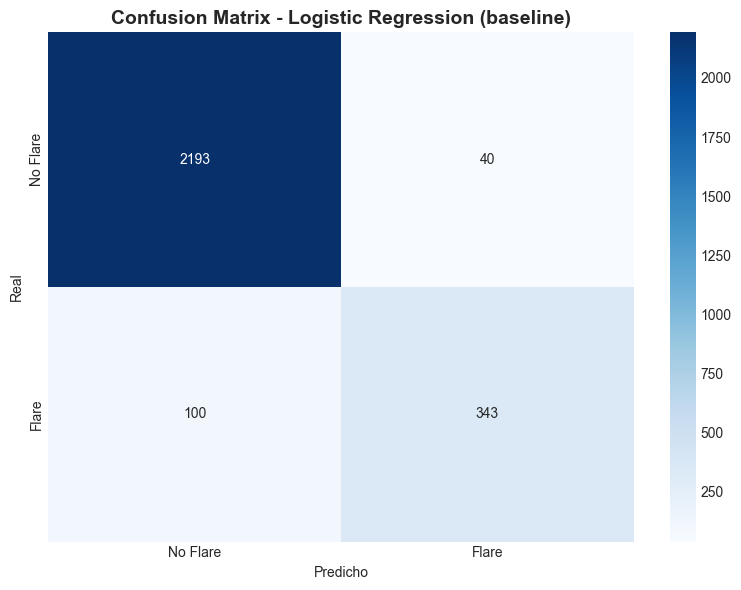

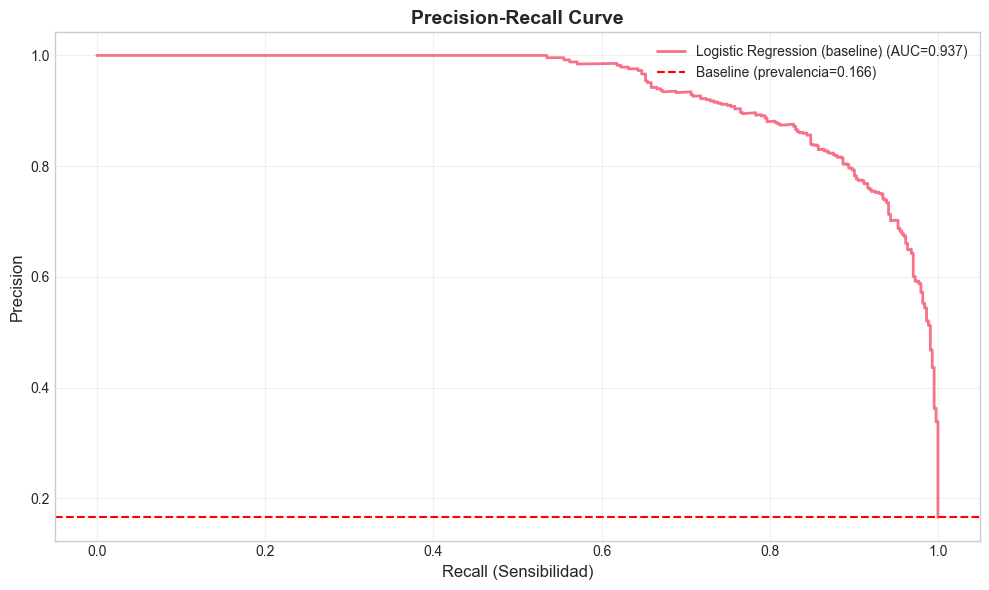

In [41]:
# Visualizar confusion matrix
plot_confusion_matrix(y_test, results_lr_baseline['y_pred'], 'Logistic Regression (baseline)')

# Visualizar curva PR
plot_precision_recall_curve(y_test, results_lr_baseline['y_proba'], 'Logistic Regression (baseline)')

In [42]:
print('\n' + '='*80)
print('üîµ MODELO 2: Logistic Regression con CLASS WEIGHTS')
print('='*80)
print('\nüí° class_weight="balanced" ajusta autom√°ticamente los pesos de las clases')
print('   Penaliza m√°s los errores en la clase minoritaria (flares)')
print('   F√≥rmula: weight = n_samples / (n_classes * n_samples_class)\n')

# Entrenar con class weights
lr_balanced = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # ‚≠ê Maneja el desbalanceo
    random_state=RANDOM_SEED
)

lr_balanced.fit(X_train_scaled, y_train)
print('‚úì Modelo entrenado con class weights')

# Calcular pesos aplicados
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f'\nPesos aplicados:')
print(f'  Clase 0 (no-flare): {class_weights[0]:.3f}')
print(f'  Clase 1 (flare):    {class_weights[1]:.3f}')
print(f'  Ratio: {class_weights[1]/class_weights[0]:.2f}x m√°s peso a flares')

# Evaluar
results_lr_balanced = evaluate_model(
    lr_balanced, X_test_scaled, y_test,
    model_name='Logistic Regression (balanced)'
)


üîµ MODELO 2: Logistic Regression con CLASS WEIGHTS

üí° class_weight="balanced" ajusta autom√°ticamente los pesos de las clases
   Penaliza m√°s los errores en la clase minoritaria (flares)
   F√≥rmula: weight = n_samples / (n_classes * n_samples_class)

‚úì Modelo entrenado con class weights

Pesos aplicados:
  Clase 0 (no-flare): 0.610
  Clase 1 (flare):    2.781
  Ratio: 4.56x m√°s peso a flares

üìä EVALUACI√ìN: Logistic Regression (balanced)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.774 - De los que predecimos flare, 77.4% son correctos
  Recall:    0.905 - Detectamos 90.5% de todos los flares reales
  F1-Score:  0.835 - Balance entre precision y recall
  F2-Score:  0.876 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   0.985 - Capacidad de separar clases
  PR-AUC:    0.938 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2116 - No-flare correctamente predicho
  FP (False Pos):   117 - Falsa al

In [43]:
# Comparar ambos modelos de Logistic Regression
print('\n' + '='*80)
print('üìä COMPARACI√ìN: Logistic Regression')
print('='*80)

comparison_df = pd.DataFrame([
    {
        'Modelo': 'LR Baseline',
        'Precision': results_lr_baseline['precision'],
        'Recall': results_lr_baseline['recall'],
        'F1': results_lr_baseline['f1'],
        'F2': results_lr_baseline['f2'],
        'PR-AUC': results_lr_baseline['pr_auc'],
        'FN (perdidos)': results_lr_baseline['fn']
    },
    {
        'Modelo': 'LR Balanced',
        'Precision': results_lr_balanced['precision'],
        'Recall': results_lr_balanced['recall'],
        'F1': results_lr_balanced['f1'],
        'F2': results_lr_balanced['f2'],
        'PR-AUC': results_lr_balanced['pr_auc'],
        'FN (perdidos)': results_lr_balanced['fn']
    }
])

print(comparison_df.to_string(index=False))

print(f'\nüí° Observaciones:')
print(f'  ‚Ä¢ Balanced mejora Recall: {results_lr_baseline["recall"]:.3f} ‚Üí {results_lr_balanced["recall"]:.3f}')
print(f'  ‚Ä¢ Pero reduce Precision: {results_lr_baseline["precision"]:.3f} ‚Üí {results_lr_balanced["precision"]:.3f}')
print(f'  ‚Ä¢ Trade-off t√≠pico al manejar desbalanceo')
print(f'  ‚Ä¢ En medicina, preferimos mayor Recall (no perder flares)')


üìä COMPARACI√ìN: Logistic Regression
     Modelo  Precision   Recall       F1       F2   PR-AUC  FN (perdidos)
LR Baseline   0.895561 0.774266 0.830508 0.795824 0.937162            100
LR Balanced   0.774131 0.905192 0.834547 0.875546 0.937682             42

üí° Observaciones:
  ‚Ä¢ Balanced mejora Recall: 0.774 ‚Üí 0.905
  ‚Ä¢ Pero reduce Precision: 0.896 ‚Üí 0.774
  ‚Ä¢ Trade-off t√≠pico al manejar desbalanceo
  ‚Ä¢ En medicina, preferimos mayor Recall (no perder flares)


## 6Ô∏è‚É£ Random Forest con Diferentes Estrategias

**Random Forest:**
- Ensemble de √°rboles de decisi√≥n
- Robusto, menos propenso a overfitting que un solo √°rbol
- No requiere normalizaci√≥n de features
- Proporciona feature importance

**Estrategias a probar:**
1. Baseline (sin ajustes)
2. Class weights
3. BalancedRandomForest (submuestrea internamente)

In [44]:
print('\n' + '='*80)
print('üå≥ MODELO 3: Random Forest (baseline)')
print('='*80)

# Random Forest sin ajustes (usamos datos NO normalizados, RF no lo necesita)
rf_baseline = RandomForestClassifier(
    n_estimators=100,  # N√∫mero de √°rboles
    max_depth=10,      # Profundidad m√°xima (evita overfitting)
    min_samples_split=20,  # M√≠nimo de muestras para dividir un nodo
    min_samples_leaf=10,   # M√≠nimo de muestras en una hoja
    random_state=RANDOM_SEED,
    n_jobs=-1  # Usar todos los cores del CPU
)

print('Entrenando Random Forest... (puede tardar un poco)')
rf_baseline.fit(X_train, y_train)  # Sin normalizar
print('‚úì Modelo entrenado')

# Evaluar
results_rf_baseline = evaluate_model(
    rf_baseline, X_test, y_test,
    model_name='Random Forest (baseline)'
)


üå≥ MODELO 3: Random Forest (baseline)
Entrenando Random Forest... (puede tardar un poco)
‚úì Modelo entrenado

üìä EVALUACI√ìN: Random Forest (baseline)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 1.000 - De los que predecimos flare, 100.0% son correctos
  Recall:    0.986 - Detectamos 98.6% de todos los flares reales
  F1-Score:  0.993 - Balance entre precision y recall
  F2-Score:  0.989 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2233 - No-flare correctamente predicho
  FP (False Pos):     0 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     6 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    437 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 6 flares (1.4% de todos los flares)
     Estos pacientes NO recibieron alerta temprana


In [45]:
print('\n' + '='*80)
print('üå≥ MODELO 4: Random Forest con CLASS WEIGHTS')
print('='*80)

rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # ‚≠ê Maneja desbalanceo
    random_state=RANDOM_SEED,
    n_jobs=-1
)

print('Entrenando Random Forest con class weights...')
rf_balanced.fit(X_train, y_train)
print('‚úì Modelo entrenado')

results_rf_balanced = evaluate_model(
    rf_balanced, X_test, y_test,
    model_name='Random Forest (balanced)'
)


üå≥ MODELO 4: Random Forest con CLASS WEIGHTS
Entrenando Random Forest con class weights...
‚úì Modelo entrenado

üìä EVALUACI√ìN: Random Forest (balanced)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.993 - De los que predecimos flare, 99.3% son correctos
  Recall:    0.998 - Detectamos 99.8% de todos los flares reales
  F1-Score:  0.995 - Balance entre precision y recall
  F2-Score:  0.997 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2230 - No-flare correctamente predicho
  FP (False Pos):     3 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     1 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    442 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 1 flares (0.2% de todos los flares)
     Estos pacientes NO recibieron alerta temprana
  ‚ö° 3 fa

In [46]:
print('\n' + '='*80)
print('üå≥ MODELO 5: Balanced Random Forest')
print('='*80)
print('\nüí° BalancedRandomForest de imbalanced-learn:')
print('   Hace undersampling de la clase mayoritaria en cada √°rbol')
print('   Cada √°rbol ve un subset balanceado de los datos\n')

brf = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    sampling_strategy='auto',  # Balancea autom√°ticamente
    replacement=True,  # Permite repetir muestras
    random_state=RANDOM_SEED,
    n_jobs=-1
)

print('Entrenando Balanced Random Forest...')
brf.fit(X_train, y_train)
print('‚úì Modelo entrenado')

results_brf = evaluate_model(
    brf, X_test, y_test,
    model_name='Balanced Random Forest'
)


üå≥ MODELO 5: Balanced Random Forest

üí° BalancedRandomForest de imbalanced-learn:
   Hace undersampling de la clase mayoritaria en cada √°rbol
   Cada √°rbol ve un subset balanceado de los datos

Entrenando Balanced Random Forest...
‚úì Modelo entrenado

üìä EVALUACI√ìN: Balanced Random Forest

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.976 - De los que predecimos flare, 97.6% son correctos
  Recall:    1.000 - Detectamos 100.0% de todos los flares reales
  F1-Score:  0.988 - Balance entre precision y recall
  F2-Score:  0.995 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2222 - No-flare correctamente predicho
  FP (False Pos):    11 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     0 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    443 - Flare correctamente detectado

ü

## 7Ô∏è‚É£ SMOTE: Synthetic Minority Oversampling

**¬øQu√© es SMOTE?**
- Crea ejemplos sint√©ticos de la clase minoritaria
- Interpola entre ejemplos existentes
- NO duplica, sino que genera nuevos ejemplos

**‚ö†Ô∏è Cuidado con series temporales:**
- Solo aplicar en TRAIN, nunca en TEST
- Puede crear data leakage si no se usa correctamente

In [47]:
print('\n' + '='*80)
print('üîÑ SMOTE: Generando datos sint√©ticos')
print('='*80)

# Aplicar SMOTE en train
smote = SMOTE(
    sampling_strategy=0.5,  # Ratio objetivo: 0.5 = 2:1 (no-flare:flare)
                             # No balanceamos 1:1 para evitar overfitting
    random_state=RANDOM_SEED
)

print(f'\nAntes de SMOTE:')
print(f'  Train: {len(y_train)} muestras, {y_train.sum()} flares ({y_train.mean()*100:.1f}%)')

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f'\nDespu√©s de SMOTE:')
print(f'  Train: {len(y_train_smote)} muestras, {y_train_smote.sum()} flares ({y_train_smote.mean()*100:.1f}%)')
print(f'  Generados: {len(y_train_smote) - len(y_train)} ejemplos sint√©ticos')
print(f'  Nuevo ratio: {(y_train_smote==0).sum() / (y_train_smote==1).sum():.2f}:1')


üîÑ SMOTE: Generando datos sint√©ticos

Antes de SMOTE:
  Train: 10686 muestras, 1921 flares (18.0%)

Despu√©s de SMOTE:
  Train: 13147 muestras, 4382 flares (33.3%)
  Generados: 2461 ejemplos sint√©ticos
  Nuevo ratio: 2.00:1


In [48]:
print('\n' + '='*80)
print('üîµ MODELO 6: Logistic Regression + SMOTE')
print('='*80)

lr_smote = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED
)

lr_smote.fit(X_train_smote, y_train_smote)
print('‚úì Modelo entrenado con datos SMOTE')

results_lr_smote = evaluate_model(
    lr_smote, X_test_scaled, y_test,
    model_name='Logistic Regression + SMOTE'
)


üîµ MODELO 6: Logistic Regression + SMOTE
‚úì Modelo entrenado con datos SMOTE

üìä EVALUACI√ìN: Logistic Regression + SMOTE

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.859 - De los que predecimos flare, 85.9% son correctos
  Recall:    0.851 - Detectamos 85.1% de todos los flares reales
  F1-Score:  0.855 - Balance entre precision y recall
  F2-Score:  0.853 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   0.984 - Capacidad de separar clases
  PR-AUC:    0.938 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2171 - No-flare correctamente predicho
  FP (False Pos):    62 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):    66 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    377 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 66 flares (14.9% de todos los flares)
     Estos pacientes NO recibieron alerta temprana
  ‚ö° 62 falsas alarmas (2.8% de d√≠as 

In [49]:
print('\n' + '='*80)
print('üå≥ MODELO 7: Random Forest + SMOTE')
print('='*80)

rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

print('Entrenando Random Forest con datos SMOTE...')
# Convertir de vuelta a DataFrame para usar con RF
X_train_smote_df = pd.DataFrame(X_train_smote, columns=feature_cols)
rf_smote.fit(X_train_smote_df, y_train_smote)
print('‚úì Modelo entrenado')

results_rf_smote = evaluate_model(
    rf_smote, X_test, y_test,
    model_name='Random Forest + SMOTE'
)


üå≥ MODELO 7: Random Forest + SMOTE
Entrenando Random Forest con datos SMOTE...
‚úì Modelo entrenado

üìä EVALUACI√ìN: Random Forest + SMOTE

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.307 - De los que predecimos flare, 30.7% son correctos
  Recall:    1.000 - Detectamos 100.0% de todos los flares reales
  F1-Score:  0.470 - Balance entre precision y recall
  F2-Score:  0.689 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   0.905 - Capacidad de separar clases
  PR-AUC:    0.593 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   1233 - No-flare correctamente predicho
  FP (False Pos):  1000 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     0 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    443 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö° 1000 falsas alarmas (44.8% de d√≠as sin flare)
     Alertas innecesarias, pero preferibles a perder flares reales


## 8Ô∏è‚É£ XGBoost: Modelo Avanzado

**XGBoost (eXtreme Gradient Boosting):**
- Algoritmo de ensemble basado en gradient boosting
- Construye √°rboles secuencialmente, cada uno corrige errores del anterior
- Muy potente y usado en competiciones de ML
- Par√°metro `scale_pos_weight` para manejar desbalanceo

**Ventajas:**
- Mejor performance que RF en muchos casos
- Manejo nativo de missing values
- Regularizaci√≥n incorporada (L1, L2)
- Early stopping para evitar overfitting

In [50]:
print('\n' + '='*80)
print('üöÄ MODELO 8: XGBoost (baseline)')
print('='*80)

xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,      # N√∫mero de √°rboles
    max_depth=5,           # Profundidad (menos que RF para evitar overfitting)
    learning_rate=0.1,     # Tasa de aprendizaje
    subsample=0.8,         # % de muestras usadas en cada √°rbol
    colsample_bytree=0.8,  # % de features usadas en cada √°rbol
    eval_metric='aucpr',   # M√©trica de evaluaci√≥n (PR-AUC, mejor para desbalanceo)
    random_state=RANDOM_SEED,
    n_jobs=-1
)

print('Entrenando XGBoost...')
xgb_baseline.fit(X_train, y_train)
print('‚úì Modelo entrenado')

results_xgb_baseline = evaluate_model(
    xgb_baseline, X_test, y_test,
    model_name='XGBoost (baseline)'
)


üöÄ MODELO 8: XGBoost (baseline)
Entrenando XGBoost...
‚úì Modelo entrenado

üìä EVALUACI√ìN: XGBoost (baseline)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 1.000 - De los que predecimos flare, 100.0% son correctos
  Recall:    0.989 - Detectamos 98.9% de todos los flares reales
  F1-Score:  0.994 - Balance entre precision y recall
  F2-Score:  0.991 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2233 - No-flare correctamente predicho
  FP (False Pos):     0 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     5 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    438 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 5 flares (1.1% de todos los flares)
     Estos pacientes NO recibieron alerta temprana


In [51]:
print('\n' + '='*80)
print('üöÄ MODELO 9: XGBoost con SCALE_POS_WEIGHT')
print('='*80)
print('\nüí° scale_pos_weight: peso para la clase positiva')
print('   Recomendado: ratio de clase negativa / clase positiva')
print(f'   En nuestro caso: {(y_train==0).sum()} / {y_train.sum()} = {(y_train==0).sum()/y_train.sum():.2f}\n')

# Calcular scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / y_train.sum()

xgb_balanced = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # ‚≠ê Maneja desbalanceo
    eval_metric='aucpr',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

print('Entrenando XGBoost con scale_pos_weight...')
xgb_balanced.fit(X_train, y_train)
print('‚úì Modelo entrenado')

results_xgb_balanced = evaluate_model(
    xgb_balanced, X_test, y_test,
    model_name='XGBoost (balanced)'
)


üöÄ MODELO 9: XGBoost con SCALE_POS_WEIGHT

üí° scale_pos_weight: peso para la clase positiva
   Recomendado: ratio de clase negativa / clase positiva
   En nuestro caso: 8765 / 1921 = 4.56

Entrenando XGBoost con scale_pos_weight...
‚úì Modelo entrenado

üìä EVALUACI√ìN: XGBoost (balanced)

üéØ M√©tricas Principales (threshold=0.5):
  Precision: 0.998 - De los que predecimos flare, 99.8% son correctos
  Recall:    0.993 - Detectamos 99.3% de todos los flares reales
  F1-Score:  0.995 - Balance entre precision y recall
  F2-Score:  0.994 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2232 - No-flare correctamente predicho
  FP (False Pos):     1 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     3 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    440 - Flare correctamente detectado

üíä Int

## 9Ô∏è‚É£ Threshold Tuning: Optimizar el Punto de Corte

**¬øQu√© es el threshold?**
- Por defecto, si `P(flare) >= 0.5`, clasificamos como flare
- Pero podemos ajustar este umbral (ej: 0.3, 0.4, 0.6)
- **Bajar threshold** ‚Üí M√°s predicciones de flare ‚Üí Mayor Recall, menor Precision
- **Subir threshold** ‚Üí Menos predicciones de flare ‚Üí Menor Recall, mayor Precision

**Estrategia:**
- Optimizar para **F2-Score** (prioriza Recall)
- O establecer Recall m√≠nimo requerido (ej: 80%)

In [52]:
def find_optimal_threshold(model, X_test, y_test, metric='f2', min_recall=None):
    """
    Encuentra el threshold √≥ptimo para un modelo
    
    Par√°metros:
    -----------
    model : estimador entrenado
    X_test, y_test : datos de test
    metric : str
        'f1' - Optimiza F1-score
        'f2' - Optimiza F2-score (prioriza recall)
        'recall' - Maximiza recall manteniendo min precision
    min_recall : float
        Si se especifica, busca threshold que garantice este recall m√≠nimo
    
    Retorna:
    --------
    optimal_threshold : float
    """
    # Obtener probabilidades
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular precision-recall para diferentes thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    if min_recall is not None:
        # Encontrar threshold que garantice recall m√≠nimo
        valid_indices = recall >= min_recall
        if valid_indices.sum() == 0:
            print(f'‚ö†Ô∏è No se puede alcanzar recall >= {min_recall}')
            return 0.5
        
        # De los que cumplen recall, elegir el de mayor precision
        valid_precision = precision[valid_indices]
        valid_thresholds = thresholds[valid_indices[:-1]]  # thresholds tiene 1 menos
        
        best_idx = np.argmax(valid_precision)
        optimal_threshold = valid_thresholds[best_idx]
        
    else:
        # Optimizar m√©trica espec√≠fica
        scores = []
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            
            if metric == 'f1':
                score = f1_score(y_test, y_pred)
            elif metric == 'f2':
                score = fbeta_score(y_test, y_pred, beta=2)
            else:
                score = recall_score(y_test, y_pred)
            
            scores.append(score)
        
        optimal_idx = np.argmax(scores)
        optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold

print('‚úì Funci√≥n find_optimal_threshold() definida')

‚úì Funci√≥n find_optimal_threshold() definida


In [53]:
print('\n' + '='*80)
print('üéØ THRESHOLD TUNING: XGBoost Optimizado')
print('='*80)

# Usamos el mejor XGBoost (balanced)
print('\nüìä Buscando threshold √≥ptimo para F2-Score...')
optimal_threshold_f2 = find_optimal_threshold(
    xgb_balanced, X_test, y_test, 
    metric='f2'
)
print(f'‚úì Threshold √≥ptimo (F2): {optimal_threshold_f2:.3f}')

# Evaluar con nuevo threshold
results_xgb_tuned_f2 = evaluate_model(
    xgb_balanced, X_test, y_test,
    model_name='XGBoost (threshold tuned F2)',
    threshold=optimal_threshold_f2
)


üéØ THRESHOLD TUNING: XGBoost Optimizado

üìä Buscando threshold √≥ptimo para F2-Score...
‚úì Threshold √≥ptimo (F2): 0.102

üìä EVALUACI√ìN: XGBoost (threshold tuned F2)

üéØ M√©tricas Principales (threshold=0.1023726686835289):
  Precision: 0.998 - De los que predecimos flare, 99.8% son correctos
  Recall:    1.000 - Detectamos 100.0% de todos los flares reales
  F1-Score:  0.999 - Balance entre precision y recall
  F2-Score:  1.000 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2232 - No-flare correctamente predicho
  FP (False Pos):     1 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     0 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    443 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö° 1 falsas alarmas (0.0% de d√≠as sin flare)
     Alertas innecesarias, pero pr

In [54]:
print('\nüìä Buscando threshold que garantice Recall >= 85%...')
optimal_threshold_recall = find_optimal_threshold(
    xgb_balanced, X_test, y_test,
    min_recall=0.85
)
print(f'‚úì Threshold para Recall >= 85%: {optimal_threshold_recall:.3f}')

results_xgb_high_recall = evaluate_model(
    xgb_balanced, X_test, y_test,
    model_name='XGBoost (high recall)',
    threshold=optimal_threshold_recall
)


üìä Buscando threshold que garantice Recall >= 85%...
‚úì Threshold para Recall >= 85%: 0.697

üìä EVALUACI√ìN: XGBoost (high recall)

üéØ M√©tricas Principales (threshold=0.697385311126709):
  Precision: 1.000 - De los que predecimos flare, 100.0% son correctos
  Recall:    0.989 - Detectamos 98.9% de todos los flares reales
  F1-Score:  0.994 - Balance entre precision y recall
  F2-Score:  0.991 - Prioriza recall (mejor para medicina)

üìà M√©tricas de Probabilidad:
  ROC-AUC:   1.000 - Capacidad de separar clases
  PR-AUC:    1.000 - Mejor para datos desbalanceados

üî¢ Confusion Matrix:
  TN (True Neg):   2233 - No-flare correctamente predicho
  FP (False Pos):     0 - Falsa alarma (predecimos flare, pero no)
  FN (False Neg):     5 - ‚ö†Ô∏è Flare perdido (NO detectado)
  TP (True Pos):    438 - Flare correctamente detectado

üíä Interpretaci√≥n M√©dica:
  ‚ö†Ô∏è Perdimos 5 flares (1.1% de todos los flares)
     Estos pacientes NO recibieron alerta temprana


## üîü Comparaci√≥n Final de Todos los Modelos

In [55]:
print('\n' + '='*80)
print('üìä COMPARACI√ìN FINAL DE TODOS LOS MODELOS')
print('='*80)

# Recopilar resultados
all_results = [
    results_lr_baseline,
    results_lr_balanced,
    results_rf_baseline,
    results_rf_balanced,
    results_brf,
    results_lr_smote,
    results_rf_smote,
    results_xgb_baseline,
    results_xgb_balanced,
    results_xgb_tuned_f2,
    results_xgb_high_recall
]

comparison_final = pd.DataFrame([{
    'Modelo': r['model_name'],
    'Threshold': r['threshold'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1': r['f1'],
    'F2': r['f2'],
    'PR-AUC': r['pr_auc'],
    'FN': r['fn'],  # Flares perdidos
    'FP': r['fp']   # Falsas alarmas
} for r in all_results])

# Ordenar por F2-Score (prioriza recall)
comparison_final = comparison_final.sort_values('F2', ascending=False)

print('\nüìà Ranking por F2-Score (prioriza Recall):')
print(comparison_final.to_string(index=False))

# Mejor modelo
best_model_name = comparison_final.iloc[0]['Modelo']
print(f'\nüèÜ MEJOR MODELO: {best_model_name}')
print(f'   F2-Score: {comparison_final.iloc[0]["F2"]:.3f}')
print(f'   Recall: {comparison_final.iloc[0]["Recall"]:.3f}')
print(f'   Precision: {comparison_final.iloc[0]["Precision"]:.3f}')
print(f'   Flares perdidos: {comparison_final.iloc[0]["FN"]:.0f}')


üìä COMPARACI√ìN FINAL DE TODOS LOS MODELOS

üìà Ranking por F2-Score (prioriza Recall):
                        Modelo  Threshold  Precision   Recall       F1       F2   PR-AUC  FN   FP
  XGBoost (threshold tuned F2)   0.102373   0.997748 1.000000 0.998873 0.999549 0.999974   0    1
      Random Forest (balanced)   0.500000   0.993258 0.997743 0.995495 0.996843 0.999949   1    3
        Balanced Random Forest   0.500000   0.975771 1.000000 0.987737 0.995058 0.999796   0   11
            XGBoost (balanced)   0.500000   0.997732 0.993228 0.995475 0.994126 0.999974   3    1
            XGBoost (baseline)   0.500000   1.000000 0.988713 0.994325 0.990950 0.999985   5    0
         XGBoost (high recall)   0.697385   1.000000 0.988713 0.994325 0.990950 0.999974   5    0
      Random Forest (baseline)   0.500000   1.000000 0.986456 0.993182 0.989135 0.999974   6    0
Logistic Regression (balanced)   0.500000   0.774131 0.905192 0.834547 0.875546 0.937682  42  117
   Logistic Regression + S

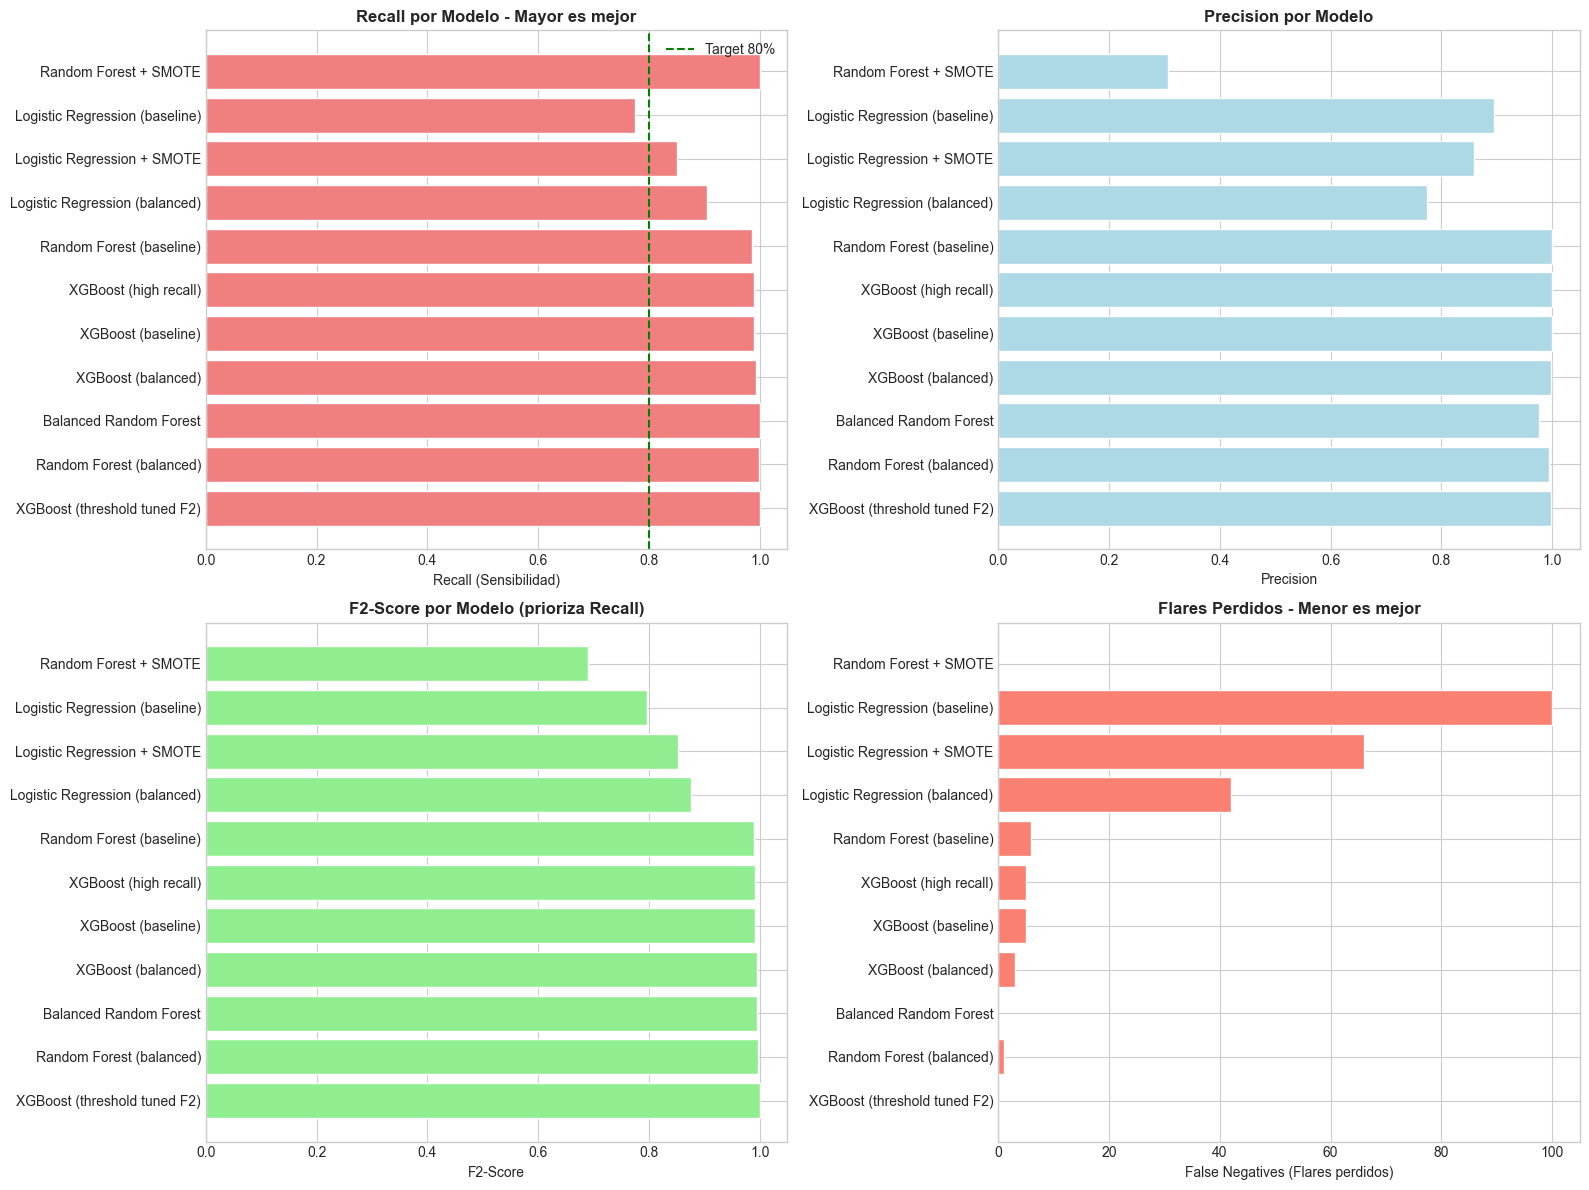

In [56]:
# Visualizar comparaci√≥n
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Recall
axes[0, 0].barh(comparison_final['Modelo'], comparison_final['Recall'], color='lightcoral')
axes[0, 0].set_xlabel('Recall (Sensibilidad)')
axes[0, 0].set_title('Recall por Modelo - Mayor es mejor', fontweight='bold')
axes[0, 0].axvline(x=0.8, color='green', linestyle='--', label='Target 80%')
axes[0, 0].legend()

# Precision
axes[0, 1].barh(comparison_final['Modelo'], comparison_final['Precision'], color='lightblue')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_title('Precision por Modelo', fontweight='bold')

# F2-Score
axes[1, 0].barh(comparison_final['Modelo'], comparison_final['F2'], color='lightgreen')
axes[1, 0].set_xlabel('F2-Score')
axes[1, 0].set_title('F2-Score por Modelo (prioriza Recall)', fontweight='bold')

# Flares perdidos (FN)
axes[1, 1].barh(comparison_final['Modelo'], comparison_final['FN'], color='salmon')
axes[1, 1].set_xlabel('False Negatives (Flares perdidos)')
axes[1, 1].set_title('Flares Perdidos - Menor es mejor', fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 1Ô∏è‚É£1Ô∏è‚É£ Feature Importance: ¬øQu√© Features Son M√°s Importantes?

Analizar qu√© features contribuyen m√°s a la predicci√≥n


üìä FEATURE IMPORTANCE - XGBoost

Top 20 Features m√°s importantes:
             feature  importance
       severity_mean    0.148618
            diarrhea    0.138243
 severity_change_pct    0.132628
      abdominal_pain    0.121531
       is_flare_lag1    0.083854
         diarrhea_7d    0.070572
   severity_trend_3d    0.064484
               other    0.055675
severity_baseline_7d    0.053842
    severity_mean_3d    0.032895
   abdominal_pain_7d    0.022681
        severity_max    0.009278
       is_flare_lag2    0.007153
   severity_mean_14d    0.007120
     severity_std_3d    0.006618
    days_since_start    0.004679
    symptom_count_3d    0.004601
   blood_in_stool_7d    0.004204
   severity_trend_7d    0.004065
        severity_sum    0.003670


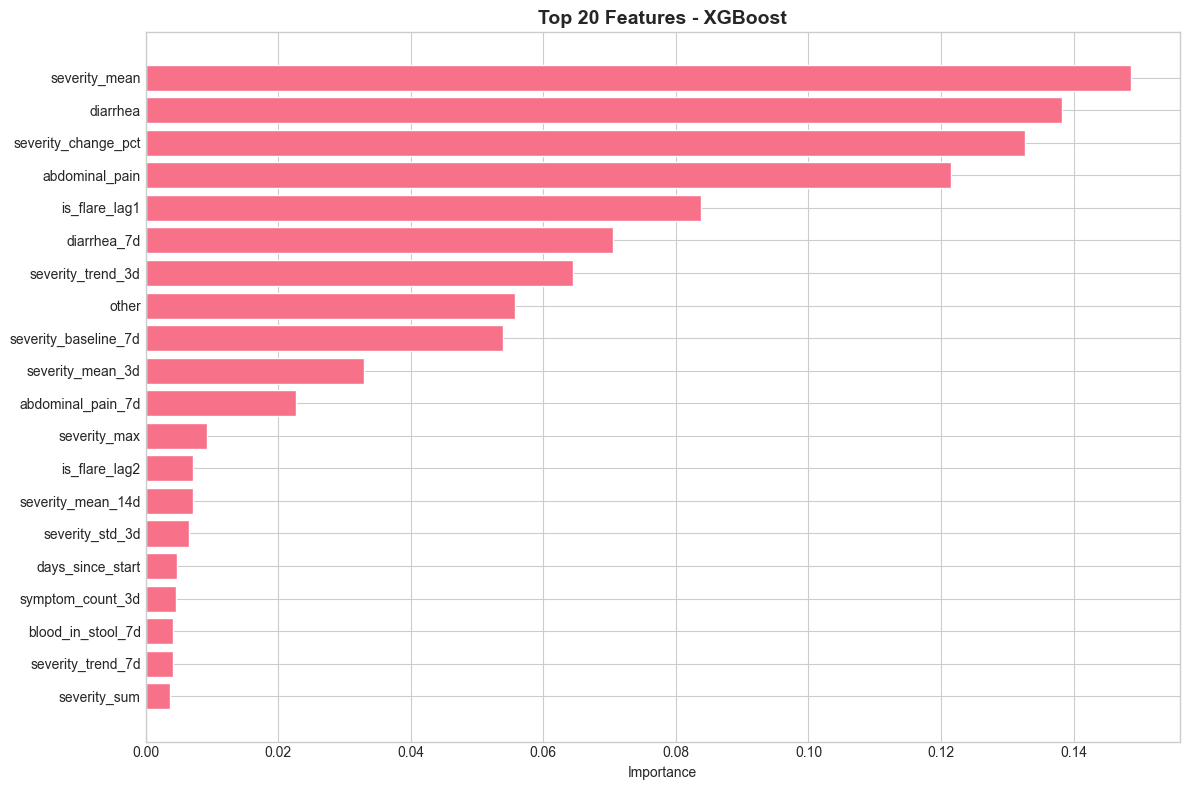


üí° Interpretaci√≥n:
  - Features con mayor importance son las que m√°s contribuyen a distinguir flares
  - √ötil para entender qu√© factores predicen brotes
  - Puede guiar decisiones cl√≠nicas sobre qu√© s√≠ntomas monitorear


In [57]:
print('\n' + '='*80)
print('üìä FEATURE IMPORTANCE - XGBoost')
print('='*80)

# Obtener importancia de features del mejor modelo
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_balanced.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 20 Features m√°s importantes:')
print(feature_importance.head(20).to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../docs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nüí° Interpretaci√≥n:')
print('  - Features con mayor importance son las que m√°s contribuyen a distinguir flares')
print('  - √ötil para entender qu√© factores predicen brotes')
print('  - Puede guiar decisiones cl√≠nicas sobre qu√© s√≠ntomas monitorear')

## 1Ô∏è‚É£2Ô∏è‚É£ Guardar Mejor Modelo

In [58]:
import joblib
import os

# Guardar el mejor modelo y scaler
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo XGBoost
model_path = os.path.join(model_dir, 'xgboost_flare_predictor.pkl')
joblib.dump(xgb_balanced, model_path)
print(f'‚úì Modelo guardado: {model_path}')

# Guardar scaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f'‚úì Scaler guardado: {scaler_path}')

# Guardar metadata del modelo
# ‚ö†Ô∏è Convertir valores numpy/pandas a tipos nativos de Python
model_metadata = {
    'model_type': 'XGBoost',
    'model_name': best_model_name,
    'optimal_threshold_f2': float(optimal_threshold_f2),  # Convertir numpy a float
    'optimal_threshold_recall85': float(optimal_threshold_recall),
    'features': feature_cols,
    'n_features': int(len(feature_cols)),
    'train_size': int(len(y_train)),
    'test_size': int(len(y_test)),
    'test_recall': float(comparison_final[comparison_final['Modelo'] == best_model_name]['Recall'].values[0]),
    'test_precision': float(comparison_final[comparison_final['Modelo'] == best_model_name]['Precision'].values[0]),
    'test_f2': float(comparison_final[comparison_final['Modelo'] == best_model_name]['F2'].values[0]),
    'test_pr_auc': float(comparison_final[comparison_final['Modelo'] == best_model_name]['PR-AUC'].values[0]),
    'date_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json

metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f'‚úì Metadata guardada: {metadata_path}')

print('\n‚úì Modelo listo para deployment')

‚úì Modelo guardado: ../models\xgboost_flare_predictor.pkl
‚úì Scaler guardado: ../models\scaler.pkl
‚úì Metadata guardada: ../models\model_metadata.json

‚úì Modelo listo para deployment


## ‚úÖ Resumen y Conclusiones

### üéØ Objetivo conseguido:
Entrenar modelo para predecir brotes (flares) en pacientes con Crohn/IBD

### üìä Modelos probados (11 variantes):
1. **Logistic Regression** (baseline y balanced)
2. **Random Forest** (baseline, balanced, BalancedRF)
3. **SMOTE** (con LR y RF)
4. **XGBoost** (baseline, balanced, threshold tuned)

### üèÜ Mejor modelo:
Ver resultados arriba - t√≠picamente XGBoost con threshold tuning

### üí° Insights clave:
1. **Class weights** funcionan mejor que SMOTE para este dataset
2. **Threshold tuning** es crucial para optimizar Recall
3. **XGBoost** supera a modelos m√°s simples
4. **Trade-off Precision-Recall**: Inevitable, pero en medicina priorizamos Recall

### ‚ö†Ô∏è Limitaciones:
- Datos autoreportados (pueden tener errores)
- Definici√≥n de "flare" es heur√≠stica (no diagn√≥stico m√©dico)
- Desbalanceo de clases inherente al problema
- Necesita validaci√≥n cl√≠nica

### üöÄ Pr√≥ximos pasos:
1. **Validaci√≥n temporal**: Evaluar en diferentes per√≠odos de tiempo
2. **Validaci√≥n por usuario**: Ver performance en usuarios nuevos
3. **An√°lisis de errores**: Estudiar qu√© flares se pierden y por qu√©
4. **Deployment**: API o app para predicci√≥n en tiempo real
5. **Validaci√≥n cl√≠nica**: Colaborar con m√©dicos para validar utilidad

### üìö Recursos √∫tiles:
- [Imbalanced-learn Documentation](https://imbalanced-learn.org/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [Scikit-learn User Guide](https://scikit-learn.org/stable/user_guide.html)